<a href="https://colab.research.google.com/github/ngupta23/fastai_notebooks/blob/master/lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/images/0001TP_006750.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/labels/0001TP_006750_P.png')]

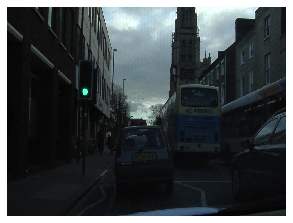

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
# What is the next cell doing (checking here) - Stem and Suffix works on paths
print(img_f)
print(img_f.stem)
print(img_f.suffix)

C:\Users\Nikhil\.fastai\data\camvid\images\0001TP_006690.png
0001TP_006690
.png


In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

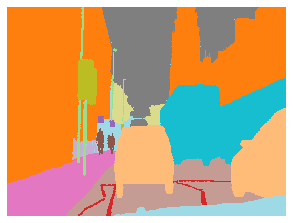

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
# What is the next line doing - check here
print(mask.shape)
src_size = np.array(mask.shape[1:]) # takes only rows and columns
print(src_size)
print(mask.data)

torch.Size([1, 720, 960])
[720 960]
tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30]]])


In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

### <font color=red> Use a source size of half. We can use transfer learning after this wih full size for faster training </font>

In [14]:
size = src_size//2  

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 4018MB of GPU RAM free


### <font color=red>**They have provided what pictures to use for the validation set. This is because the images are coming from videos so we dont want adjacent images in the video to reside in training and validation set**</font>

In [15]:
valid = np.loadtxt(path/'valid.txt', dtype=str); valid

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

**The data block API lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:**
1. Where are the inputs and how to create them?
2. How to split the data into a training and validation sets?
3. How to label the inputs?
4. What transforms to apply?
5. How to add a test set?
6. How to wrap in dataloaders and create the DataBunch?

### <font color=red> Split using filename file </font>

In [16]:
# doc(SegmentationItemList.split_by_fname_file)

In [17]:
path_img  

WindowsPath('C:/Users/Nikhil/.fastai/data/camvid/images')

In [18]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))  # classes = codes will tell it what each pixel value means

### <font color=red> Transforming y since there is a 1:1 match between image and label. If we transform image, we need to transform the label as well.</font>

In [19]:
# This can be combined in the previous step but separated since the previous step is reused later when fine tuning with a bigger image size.
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

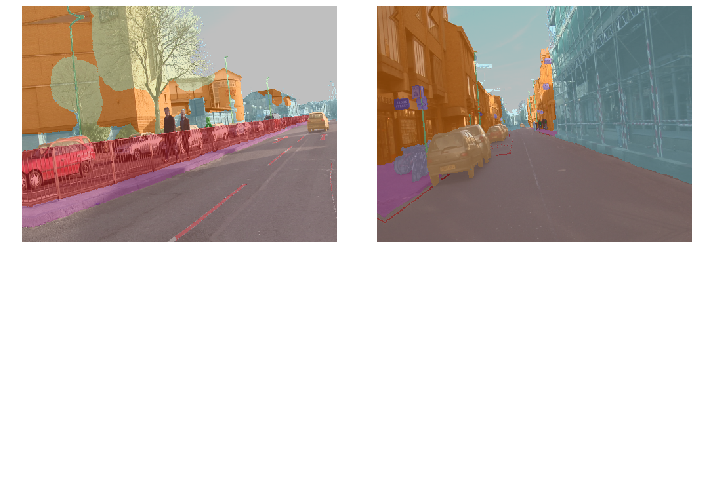

In [20]:
data.show_batch(2, figsize=(10,7))  # fastai will combine the photo with the mask and display it

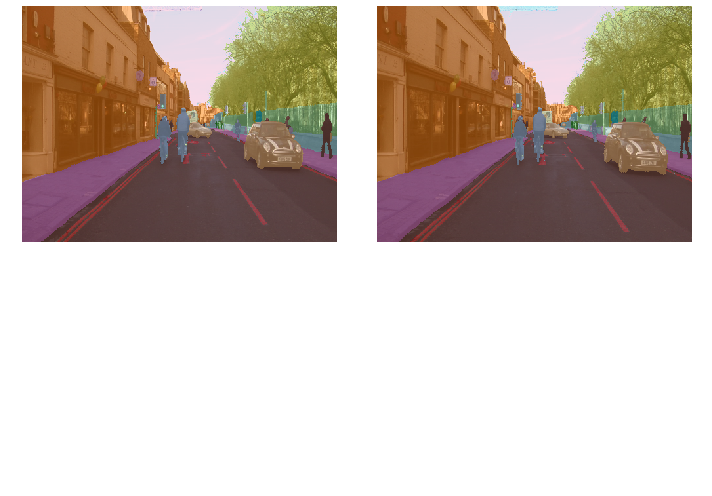

In [21]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
metrics=acc_camvid
# metrics=accuracy

In [24]:
wd=1e-2

### <font color = red> For segmentation, U-net is better than CNN (most cited paper from the conference where it was presented!!!) </font>

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

### <font color = red>You can do mixed precision training (if the size of GPU ram is not sufficient) by adding `.to_fp16()` at the end of learner. This reduces the memory requirements (16 bits instead of 32 bits), but needs the latest CUDA drivers, etc. since it is so new.</font>

`learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()`

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


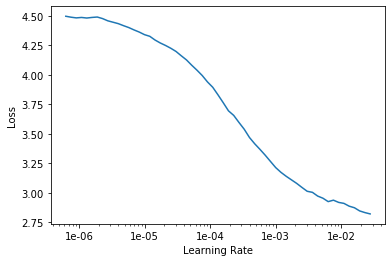

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
# lr=3e-3 from original notebook
lr = 1e-4

In [28]:
doc(learn.fit_one_cycle)

In [29]:
# learn.fit_one_cycle(10, slice(lr), pct_start=0.9)  # from originl notebook
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.191964,0.974878,0.758157,04:36
1,0.785095,0.620020,0.838679,04:30
2,0.630585,0.544521,0.863864,04:29
3,0.600435,0.492762,0.866343,04:34
4,0.512499,0.392896,0.889166,04:30
5,0.456169,0.375197,0.896734,04:29
6,0.407524,0.331727,0.904906,04:30
7,0.368518,0.313171,0.909107,04:29
8,0.348540,0.305772,0.911531,04:29
9,0.349519,0.305121,0.911832,04:29


### <font color = red> You want the loss to go up initially and then go down. This means that you have picked the best possible max learning rate. (The loss goes up initially since lr is too high so that means that you have not left anything on the table in terms of training speed.). Ofcourse this is only valid if the loss comes down eventually.</font>

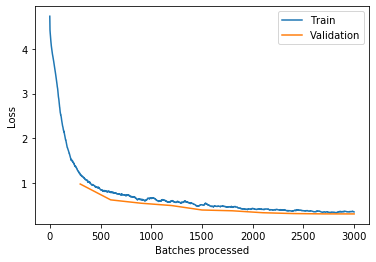

In [30]:
learn.recorder.plot_losses()

### <font color = red> Learning Rate goes up initially so that we make fast progress, cross the local minima and saddle points quickly and then the learning rate is reduced as we come closer to the global minima. The idea of reducing learning rate has been around for a while and is called learning rate annealing. But the idea of increasing the learning rate initially is fairly new (thanks to Leslie Smith).</font>

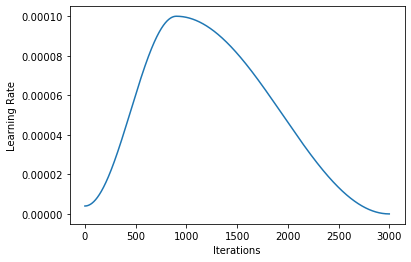

In [31]:
learn.recorder.plot_lr()  

In [32]:
learn.save('stage-1')

### <font color = red> I will stop here since it takes a lot of time to train these models. But we could essentialy go on to fine tune this model, then apply transfer learning to the full size image (with reduced batch size) </font>

In [33]:
learn.load('stage-1');

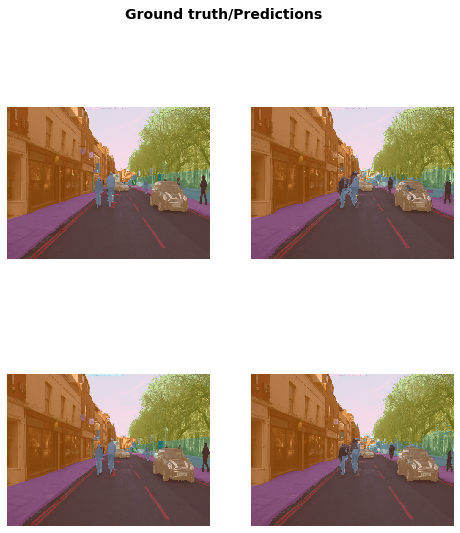

In [34]:
learn.show_results(rows=3, figsize=(8,9))

In [35]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


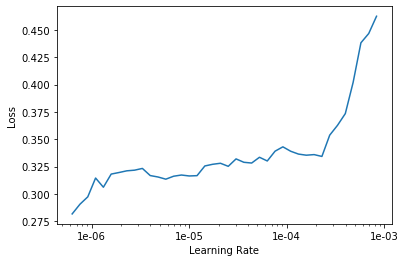

In [36]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin